In [1]:
!pip install pandas matplotlib seaborn scikit-learn statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error

In [7]:
file_path = '/content/household_power_consumption.csv'  # <-- Update path
df = pd.read_csv(file_path, sep=';', parse_dates={'Datetime': ['Date', 'Time']},
                 infer_datetime_format=True, na_values=['?'], low_memory=False)


<ipython-input-7-4183146358>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(file_path, sep=';', parse_dates={'Datetime': ['Date', 'Time']},
<ipython-input-7-4183146358>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(file_path, sep=';', parse_dates={'Datetime': ['Date', 'Time']},
<ipython-input-7-4183146358>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(file_path, sep=';', parse_dates={'Datetime': ['Date', 'Time']},


In [9]:
daily_df = df.set_index('Datetime').resample('D').mean()

In [10]:
# Select relevant features for multivariate forecasting
features = ['Global_active_power', 'Global_reactive_power', 'Voltage']
data = daily_df[features]

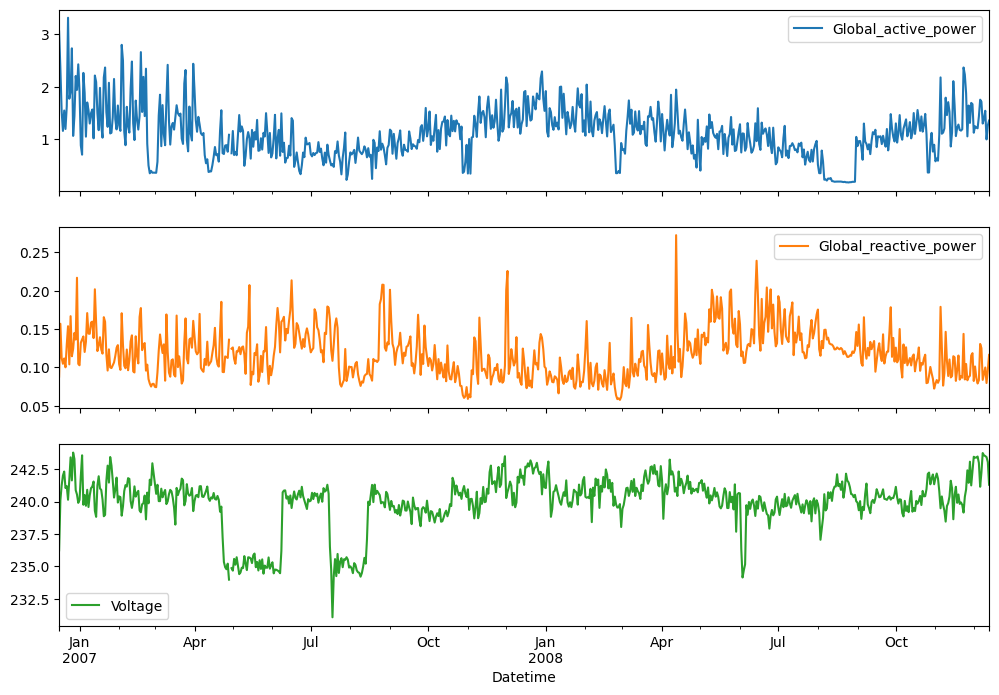

In [11]:
# Plot the series
data.plot(subplots=True, figsize=(12, 8))
plt.show()

In [12]:
# Train-Test Split
n_obs = 30  # last 30 days for testing
train = data[:-n_obs]
test = data[-n_obs:]

In [13]:
# Train VARMAX model
model = VARMAX(train, order=(2,1))  # (p, q) → p=2 lags, q=1 for MA
model_fitted = model.fit(maxiter=500, disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [14]:
# Forecast
forecast = model_fitted.forecast(steps=n_obs)
forecast.index = test.index

In [15]:
# Evaluate
for col in features:
    rmse = np.sqrt(mean_squared_error(test[col], forecast[col]))
    print(f'RMSE for {col}: {rmse:.3f}')

RMSE for Global_active_power: 0.436
RMSE for Global_reactive_power: 0.024
RMSE for Voltage: 2.090


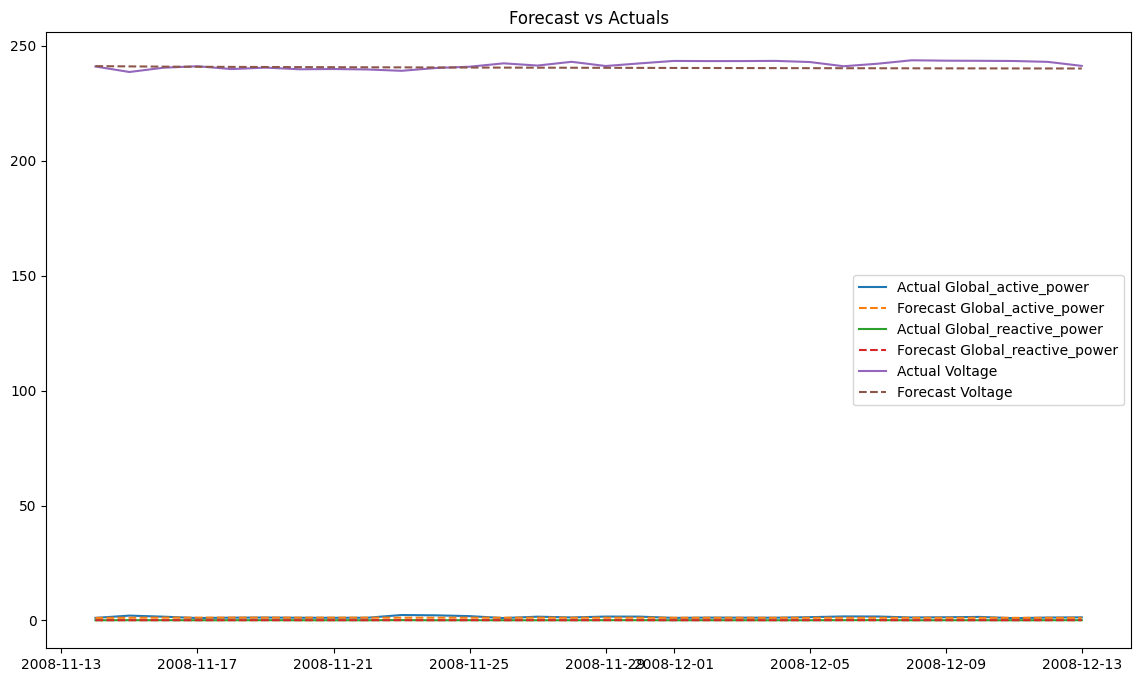

In [16]:
# Plot results
plt.figure(figsize=(14, 8))
for col in features:
    plt.plot(test.index, test[col], label=f'Actual {col}')
    plt.plot(forecast.index, forecast[col], '--', label=f'Forecast {col}')
plt.legend()
plt.title("Forecast vs Actuals")
plt.show()